In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv('data.csv')
data.info()
data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

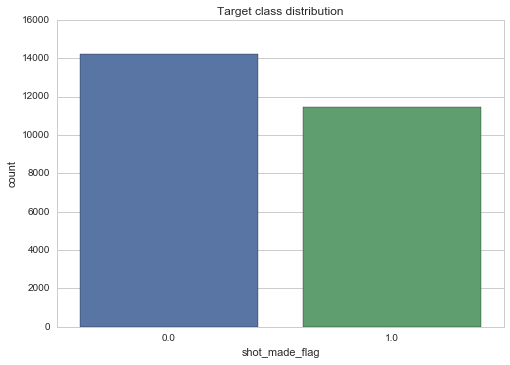

In [3]:
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

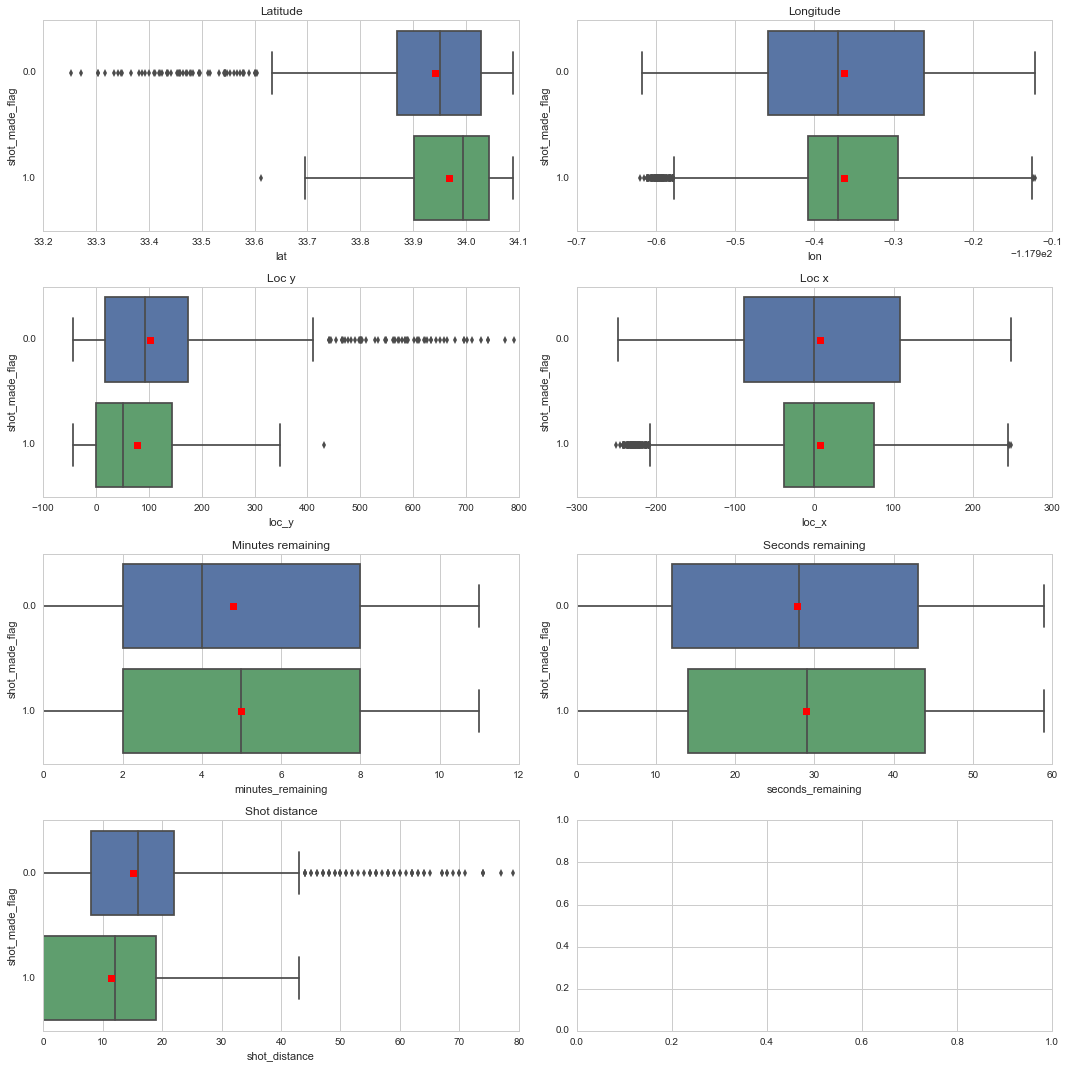

In [4]:
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0])
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0])
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1])
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0])
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1])
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0])

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes remaining')
axarr[2, 1].set_title('Seconds remaining')
axarr[3, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

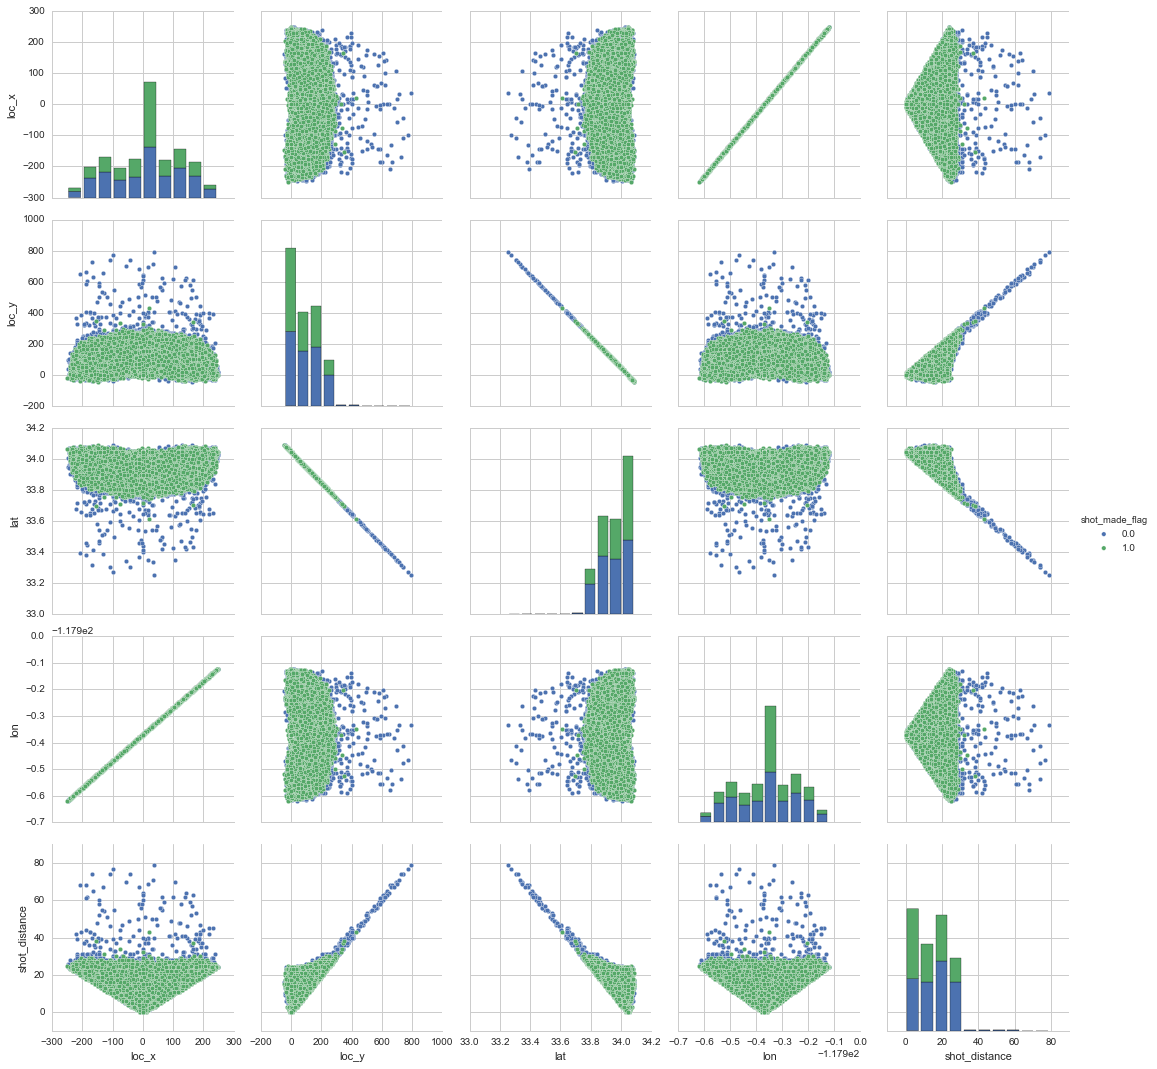

In [5]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3)
plt.show()

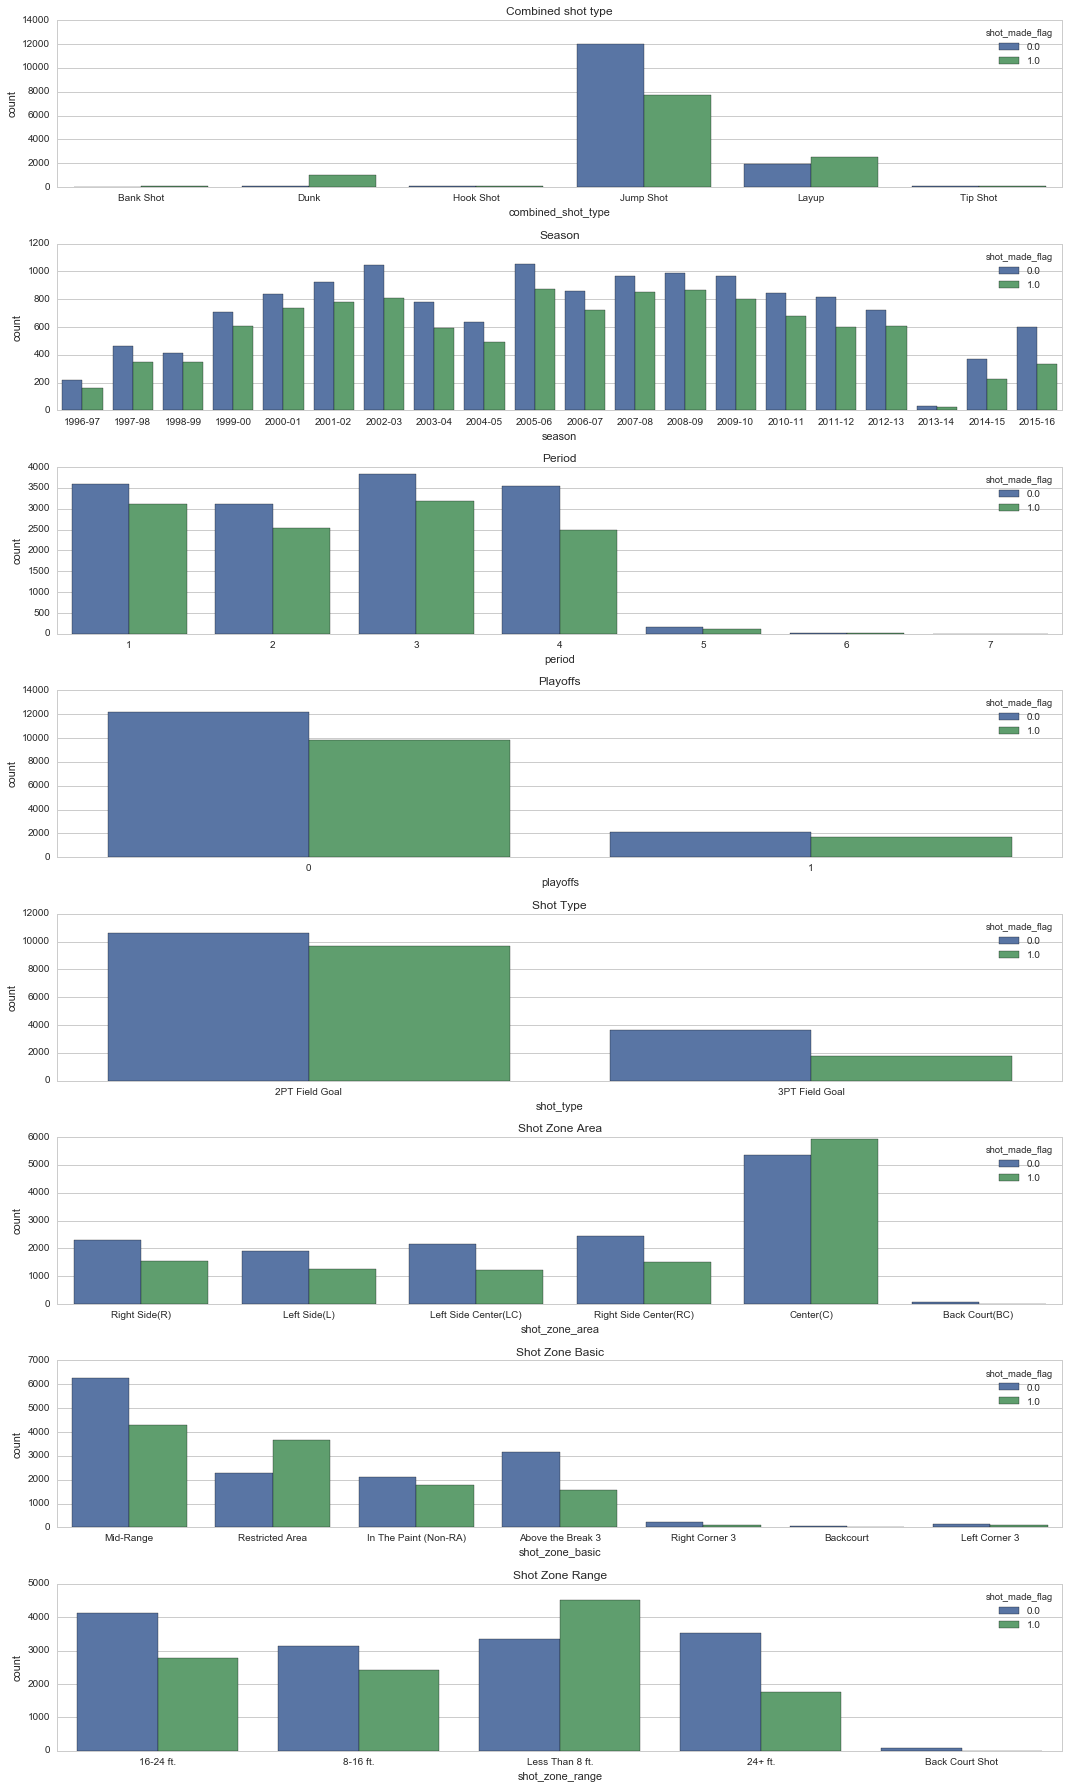

In [6]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

plt.tight_layout()
plt.show()

In [7]:
data_cl = data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

In [8]:
data_cl.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,167,72,10,1,0,2000-01,27,18,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR


In [9]:
# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

In [16]:
## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

In [18]:
data_cl.head()

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,last_5_sec_in_period,home_play,game_year,game_month
shot_id,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,"(148.4, 168.32]","(56.2, 89.6]",1,0,2000-01,18,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,False,0,2000,10
2,Jump Shot,Jump Shot,"(-170.32, -150.4]","(-10.6, 22.8]",1,0,2000-01,15,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,False,0,2000,10
3,Jump Shot,Jump Shot,"(-110.56, -90.64]","(123, 156.4]",1,0,2000-01,16,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,False,0,2000,10
4,Jump Shot,Jump Shot,"(128.48, 148.4]","(156.4, 189.8]",1,0,2000-01,22,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,False,0,2000,10
5,Driving Dunk Shot,Dunk,"(-10.96, 8.96]","(-10.6, 22.8]",2,0,2000-01,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,False,0,2000,10


In [25]:
data_cl['action_type'].value_counts().sort_values().index.values[:20]

array(['Driving Floating Bank Jump Shot',
       'Turnaround Fadeaway Bank Jump Shot',
       'Cutting Finger Roll Layup Shot', 'Running Slam Dunk Shot',
       'Turnaround Finger Roll Shot', 'Putback Slam Dunk Shot',
       'Tip Layup Shot', 'Running Tip Shot', 'Running Finger Roll Shot',
       'Running Pull-Up Jump Shot', 'Putback Dunk Shot',
       'Driving Floating Jump Shot', 'Driving Bank shot', 'Hook Bank Shot',
       'Running Finger Roll Layup Shot', 'Cutting Layup Shot',
       'Running Reverse Layup Shot', 'Pullup Bank shot',
       'Turnaround Hook Shot', 'Driving Hook Shot'], dtype=object)

In [26]:
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]


In [27]:
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'


In [28]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

In [32]:
for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [33]:
data_cl.head()

,playoffs,shot_distance,last_5_sec_in_period,home_play,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,season#1996-97,season#1997-98,season#1998-99,season#1999-00,season#2000-01,season#2001-02,season#2002-03,season#2003-04,season#2004-05,season#2005-06,season#2006-07,season#2007-08,season#2008-09,season#2009-10,season#2010-11,season#2011-12,season#2012-13,season#2013-14,season#2014-15,season#2015-16,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123]","loc_y#(123, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.

In [37]:
unknown_mask = data['shot_made_flag'].isnull()
unknown_mask

pandas.core.series.Series

In [38]:
# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

In [39]:
X.head()

,playoffs,shot_distance,last_5_sec_in_period,home_play,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,season#1996-97,season#1997-98,season#1998-99,season#1999-00,season#2000-01,season#2001-02,season#2002-03,season#2003-04,season#2004-05,season#2005-06,season#2006-07,season#2007-08,season#2008-09,season#2009-10,season#2010-11,season#2011-12,season#2012-13,season#2013-14,season#2014-15,season#2015-16,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123]","loc_y#(123, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.

In [40]:
Y.head()

shot_id
2    0.0
3    1.0
4    0.0
5    1.0
6    0.0
Name: shot_made_flag, dtype: category
Categories (2, float64): [0.0, 1.0]

In [41]:
data_cl.columns

Index([u'playoffs', u'shot_distance', u'last_5_sec_in_period', u'home_play',
       u'action_type#Alley Oop Dunk Shot', u'action_type#Alley Oop Layup shot',
       u'action_type#Driving Dunk Shot',
       u'action_type#Driving Finger Roll Layup Shot',
       u'action_type#Driving Finger Roll Shot',
       u'action_type#Driving Jump shot',
       ...
       u'loc_y#(457, 490.4]', u'loc_y#(490.4, 523.8]', u'loc_y#(523.8, 557.2]',
       u'loc_y#(557.2, 590.6]', u'loc_y#(590.6, 624]', u'loc_y#(624, 657.4]',
       u'loc_y#(657.4, 690.8]', u'loc_y#(690.8, 724.2]',
       u'loc_y#(724.2, 757.6]', u'loc_y#(757.6, 791]'],
      dtype='object', length=208)

In [44]:
threshold = 0.90
vt = VarianceThreshold().fit(X)
# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index([u'playoffs', u'shot_distance', u'home_play', u'action_type#Jump Shot',
       u'combined_shot_type#Jump Shot', u'combined_shot_type#Layup',
       u'period#1', u'period#2', u'period#3', u'period#4',
       u'shot_type#2PT Field Goal', u'shot_type#3PT Field Goal',
       u'shot_zone_area#Center(C)', u'shot_zone_area#Left Side Center(LC)',
       u'shot_zone_area#Left Side(L)', u'shot_zone_area#Right Side Center(RC)',
       u'shot_zone_area#Right Side(R)', u'shot_zone_basic#Above the Break 3',
       u'shot_zone_basic#In The Paint (Non-RA)', u'shot_zone_basic#Mid-Range',
       u'shot_zone_basic#Restricted Area', u'shot_zone_range#16-24 ft.',
       u'shot_zone_range#24+ ft.', u'shot_zone_range#8-16 ft.',
       u'shot_zone_range#Less Than 8 ft.', u'game_month#1', u'game_month#2',
       u'game_month#3', u'game_month#4', u'game_month#11', u'game_month#12',
       u'loc_x#(-10.96, 8.96]', u'loc_y#(-10.6, 22.8]', u'loc_y#(22.8, 56.2]',
       u'loc_y#(123, 156.4]'],
      dtype='ob

In [45]:
vt.variances_[:20]

array([  1.24855810e-01,   8.81447231e+01,   3.29637431e-02,
         2.49799901e-01,   3.68326231e-03,   2.60051019e-03,
         9.90114410e-03,   2.29071630e-03,   2.63922080e-03,
         8.94245007e-04,   5.93400077e-02,   3.21951645e-03,
         1.67054699e-03,   8.37325483e-03,   1.04960232e-03,
         3.27824112e-02,   1.08843408e-03,   1.01076754e-03,
         3.60600162e-03,   3.88999046e-04])

In [50]:
model = RandomForestClassifier()
model.fit(X, Y)
print model.feature_importances_
feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feature_imp

[  1.10358094e-02   5.81888012e-02   5.60444218e-03   2.68404385e-02
   5.43063190e-04   5.61215068e-04   1.39029833e-03   6.95843025e-04
   6.91061797e-04   3.17726996e-04   7.25114942e-03   8.23766365e-04
   2.35110098e-04   9.38112837e-04   4.18850563e-04   3.58643938e-03
   3.89112880e-04   3.37623187e-04   9.68535673e-04   1.52207351e-05
   8.29310901e-04   3.74901536e-03   1.52215541e-04   4.51930752e-02
   1.69693076e-02   6.63486079e-04   4.04508532e-03   2.55127891e-05
   3.64842295e-04   1.98652399e-03   0.00000000e+00   3.00182335e-04
   1.63826226e-04   1.04511610e-04   7.33125832e-03   6.54679046e-04
   3.08149297e-03   9.83188035e-04   1.57655434e-03   3.58989567e-04
   1.81498630e-03   3.48703988e-03   4.77781953e-04   8.41846498e-03
   3.71772770e-04   1.35561450e-02   3.73983983e-03   7.27828493e-04
   1.79621776e-02   1.73670868e-02   2.00348420e-02   1.64851582e-02
   2.11453616e-03   3.85734375e-04   1.00229668e-04   2.34341484e-03
   3.77898018e-03   3.48778640e-03

,importance
playoffs,0.011036
shot_distance,0.058189
last_5_sec_in_period,0.005604
home_play,0.026840
action_type#Alley Oop Dunk Shot,0.000543
action_type#Alley Oop Layup shot,0.000561
action_type#Driving Dunk Shot,0.001390
action_type#Driving Finger Roll Layup Shot,0.000696
action_type#Driving Finger Roll Shot,0.000691
action_type#Driving Jump shot,0.000318


In [51]:
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index([u'shot_distance', u'action_type#Jump Shot', u'home_play', u'period#3',
       u'period#1', u'period#2', u'action_type#Layup Shot', u'period#4',
       u'combined_shot_type#Jump Shot', u'game_month#3', u'game_month#1',
       u'game_month#4', u'game_month#12', u'playoffs', u'game_month#11',
       u'game_month#2', u'loc_x#(-10.96, 8.96]', u'opponent#PHX',
       u'opponent#SAS', u'opponent#HOU'],
      dtype='object')

In [52]:
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['combined_shot_type#Dunk', 'action_type#Jump Shot',
       'shot_zone_basic#Restricted Area', 'loc_x#(-10.96, 8.96]',
       'action_type#Driving Layup Shot', 'shot_zone_range#Less Than 8 ft.',
       'loc_y#(-10.6, 22.8]', 'action_type#Slam Dunk Shot',
       'shot_type#3PT Field Goal', 'action_type#Driving Dunk Shot',
       'shot_zone_area#Center(C)', 'action_type#Running Jump Shot',
       'shot_zone_range#24+ ft.', 'shot_zone_basic#Above the Break 3',
       'combined_shot_type#Layup', 'combined_shot_type#Jump Shot',
       'last_5_sec_in_period', 'action_type#Jump Bank Shot',
       'action_type#Pullup Jump shot',
       'shot_zone_area#Left Side Center(LC)'], dtype=object)

In [53]:
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, Y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

array(['action_type#Driving Dunk Shot',
       'action_type#Driving Finger Roll Layup Shot',
       'action_type#Driving Finger Roll Shot',
       'action_type#Driving Slam Dunk Shot', 'action_type#Dunk Shot',
       'action_type#Fadeaway Bank shot', 'action_type#Finger Roll Shot',
       'action_type#Hook Shot', 'action_type#Jump Shot',
       'action_type#Layup Shot', 'action_type#Running Bank shot',
       'action_type#Running Hook Shot', 'action_type#Slam Dunk Shot',
       'combined_shot_type#Dunk', 'combined_shot_type#Tip Shot',
       'shot_zone_area#Back Court(BC)', 'shot_zone_range#Back Court Shot',
       'loc_y#(290, 323.4]', 'loc_y#(356.8, 390.2]', 'loc_y#(390.2, 423.6]'], dtype=object)

In [55]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])
features

array(['playoffs', 'shot_distance', 'home_play', 'action_type#Jump Shot',
       'combined_shot_type#Jump Shot', 'combined_shot_type#Layup',
       'period#1', 'period#2', 'period#3', 'period#4',
       'shot_type#2PT Field Goal', 'shot_type#3PT Field Goal',
       'shot_zone_area#Center(C)', 'shot_zone_area#Left Side Center(LC)',
       'shot_zone_area#Left Side(L)',
       'shot_zone_area#Right Side Center(RC)',
       'shot_zone_area#Right Side(R)', 'shot_zone_basic#Above the Break 3',
       'shot_zone_basic#In The Paint (Non-RA)',
       'shot_zone_basic#Mid-Range', 'shot_zone_basic#Restricted Area',
       'shot_zone_range#16-24 ft.', 'shot_zone_range#24+ ft.',
       'shot_zone_range#8-16 ft.', 'shot_zone_range#Less Than 8 ft.',
       'game_month#1', 'game_month#2', 'game_month#3', 'game_month#4',
       'game_month#11', 'game_month#12', 'loc_x#(-10.96, 8.96]',
       'loc_y#(-10.6, 22.8]', 'loc_y#(22.8, 56.2]', 'loc_y#(123, 156.4]',
       'shot_distance', 'action_type#Jump Sh

In [56]:
features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-action_type#Driving Dunk Shot
	-action_type#Driving Finger Roll Layup Shot
	-action_type#Driving Finger Roll Shot
	-action_type#Driving Layup Shot
	-action_type#Driving Slam Dunk Shot
	-action_type#Dunk Shot
	-action_type#Fadeaway Bank shot
	-action_type#Finger Roll Shot
	-action_type#Hook Shot
	-action_type#Jump Bank Shot
	-action_type#Jump Shot
	-action_type#Layup Shot
	-action_type#Pullup Jump shot
	-action_type#Running Bank shot
	-action_type#Running Hook Shot
	-action_type#Running Jump Shot
	-action_type#Slam Dunk Shot
	-combined_shot_type#Dunk
	-combined_shot_type#Jump Shot
	-combined_shot_type#Layup
	-combined_shot_type#Tip Shot
	-game_month#1
	-game_month#11
	-game_month#12
	-game_month#2
	-game_month#3
	-game_month#4
	-home_play
	-last_5_sec_in_period
	-loc_x#(-10.96, 8.96]
	-loc_y#(-10.6, 22.8]
	-loc_y#(123, 156.4]
	-loc_y#(22.8, 56.2]
	-loc_y#(290, 323.4]
	-loc_y#(356.8, 390.2]
	-loc_y#(390.2, 423.6]
	-opponent#HOU
	-opponent#PHX
	-opponent#SAS
	-perio

In [60]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]
print type(data_cl)
print('Clean dataset shape: {}'.format(data_cl.shape))
print('Subbmitable dataset shape: {}'.format(data_submit.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(Y.shape))

<class 'pandas.core.frame.DataFrame'>
Clean dataset shape: (30697, 62)
Subbmitable dataset shape: (5000, 62)
Train features shape: (25697, 62)
Target label shape: (25697,)


In [62]:
components = 8
pca = PCA(n_components=components).fit(X)
pca_variance_explained_df = pd.DataFrame({
    "component": np.arange(1, components+1),
    "variance_explained": pca.explained_variance_ratio_            
    })


In [63]:
pca_variance_explained_df.head()

,component,variance_explained
0,1,0.948767
1,2,0.008897
2,3,0.004256
3,4,0.002840
4,5,0.002779


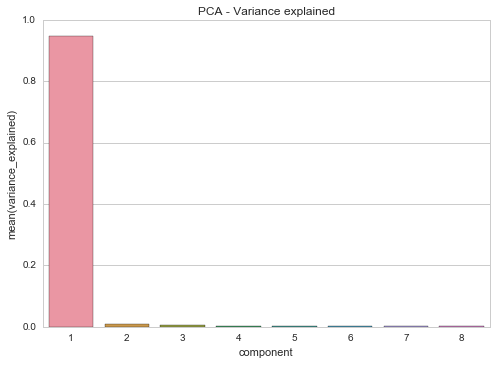

In [64]:
ax = sns.barplot(x='component', y='variance_explained', data=pca_variance_explained_df)
ax.set_title("PCA - Variance explained")
plt.show()

In [66]:
X_pca = pd.DataFrame(pca.transform(X)[:,:2])
X_pca.head()

,0,1
0,-1.558528,0.964193
1,-2.619708,1.025396
2,-8.576000,0.827577
3,13.568415,-0.625835
4,-0.598017,1.072968


In [67]:
X_pca['target'] = Y.values
X_pca.columns = ["x", "y", "target"]


In [68]:
X_pca.head()

,x,y,target
0,-1.558528,0.964193,0.0
1,-2.619708,1.025396,1.0
2,-8.576000,0.827577,0.0
3,13.568415,-0.625835,1.0
4,-0.598017,1.072968,0.0


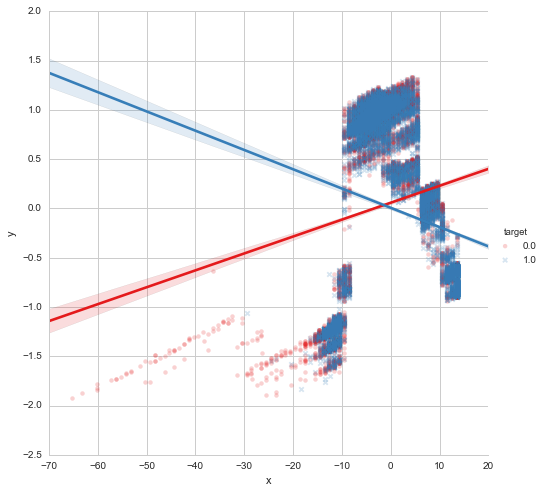

In [70]:
sns.lmplot('x','y', 
           data=X_pca, 
           hue="target", 
           fit_reg=False, 
           markers=["o", "x"], 
           palette="Set1", 
           size=7,
           scatter_kws={"alpha": .2}
          )
plt.show()

In [73]:
seed = 7
processors=1
num_folds=3
num_instances=len(X)
#scoring='log_loss'
scoring = 'accuracy'

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)

In [74]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVC', SVC(probability=True)))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (0.680) +/- (0.004)
LDA: (0.680) +/- (0.004)
K-NN: (0.603) +/- (0.013)
CART: (0.597) +/- (0.008)
NB: (0.600) +/- (0.059)


In [75]:
cart = DecisionTreeClassifier()
num_trees = 100

model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.618) +/- (0.010)


In [76]:
num_trees = 100
num_features = 10

model = RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.621) +/- (0.009)


In [77]:
num_trees = 100
num_features = 10

model = ExtraTreesClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.616) +/- (0.006)


In [78]:
model = AdaBoostClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.681) +/- (0.003)


In [79]:
model = GradientBoostingClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.680) +/- (0.004)


In [80]:
lr_grid = GridSearchCV(
    estimator = LogisticRegression(random_state=seed),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 1, 10, 100, 1000]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lr_grid.fit(X, Y)

print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.68031287699
{'penalty': 'l1', 'C': 1}


In [81]:
lda_grid = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = {
        'solver': ['lsqr'],
        'shrinkage': [0, 0.25, 0.5, 0.75, 1],
        'n_components': [None, 2, 5, 10]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lda_grid.fit(X, Y)

print(lda_grid.best_score_)
print(lda_grid.best_params_)

0.680429622135
{'shrinkage': 0, 'n_components': None, 'solver': 'lsqr'}


In [82]:
knn_grid = GridSearchCV(
    estimator = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    param_grid = {
        'knn__n_neighbors': [25],
        'knn__algorithm': ['ball_tree'],
        'knn__leaf_size': [2, 3, 4],
        'knn__p': [1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

knn_grid.fit(X, Y)

print(knn_grid.best_score_)
print(knn_grid.best_params_)

0.646301124645
{'knn__leaf_size': 3, 'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 25, 'knn__p': 1}


In [84]:
rf_grid = GridSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_features': [18, 20],
        'max_depth': [8, 10],
        'bootstrap': [True]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X, Y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.680001556602
{'max_features': 18, 'n_estimators': 100, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 10}


In [85]:
ada_grid = GridSearchCV(
    estimator = AdaBoostClassifier(random_state=seed),
    param_grid = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [10, 25, 50],
        'learning_rate': [1e-3, 1e-2, 1e-1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

ada_grid.fit(X, Y)

print(ada_grid.best_score_)
print(ada_grid.best_params_)

0.678911935245
{'n_estimators': 50, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}


In [86]:
gbm_grid = GridSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [2, 3, 4],
        'max_features': [10, 15, 20],
        'learning_rate': [1e-1, 1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

gbm_grid.fit(X, Y)

print(gbm_grid.best_score_)
print(gbm_grid.best_params_)

0.680818772619
{'max_features': 20, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 2}


In [87]:
# Create sub models
estimators = []

estimators.append(('lr', LogisticRegression(penalty='l2', C=1)))
estimators.append(('gbm', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, max_features=20, warm_start=True, random_state=seed)))
estimators.append(('rf', RandomForestClassifier(bootstrap=True, max_depth=8, n_estimators=200, max_features=20, criterion='entropy', random_state=seed)))
estimators.append(('ada', AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1e-1, n_estimators=50, random_state=seed)))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[2,3,3,1])

results = cross_val_score(ensemble, X, Y, cv=kfold, scoring=scoring,n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.681) +/- (0.004)


In [88]:
model = ensemble

model.fit(X, Y)
preds = model.predict_proba(data_submit)

submission = pd.DataFrame()
submission["shot_id"] = data_submit.index
submission["shot_made_flag"]= preds[:,0]

submission.to_csv("sub.csv",index=False)